In [1]:
from titrate.statistics import QMuTestStatistic

In [2]:
from gammapy.datasets import MapDataset                                                                                                                                     
from gammapy.irf import load_cta_irfs, load_irf_dict_from_file                                                                                                                      
from gammapy.maps import MapAxis, WcsGeom, WcsNDMap                                                                                                                         
from gammapy.modeling.models import (                                                                                                                                       
    FoVBackgroundModel,                                                                                                                                                   
    SkyModel,                                                                                                                                                               
    Models,                                                                                                                                                                 
    TemplateSpatialModel,                                                                                                                                                   
)                                                                                                                                                                           
from gammapy.data import Observation, observatory_locations                                                                                                                 
from gammapy.makers import MapDatasetMaker, SafeMaskMaker                                                                                                                   
from gammapy.astro.darkmatter import profiles, JFactory, DarkMatterAnnihilationSpectralModel                                                                                
from astropy.coordinates import SkyCoord                                                                                                                                    
import astropy.units as u                                                                                                                                                   
import numpy as np                                                                                                                                                                                                                                                                                               
import matplotlib.pyplot as plt       
import os

import astropy.constants as const

from titrate.utils import copy_models_to_dataset

In [3]:
def irfs():
    path = (
        f"{os.environ.get('GAMMAPY_DATA')}"
        f"/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    )

    irfs = load_irf_dict_from_file(path)

    return irfs


def observation():
    livetime = 50 * u.hr
    pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
    location = observatory_locations["cta_south"]
    obs = Observation.create(
        pointing=pointing, livetime=livetime, irfs=irfs(), location=location
    )

    return obs


def energy_axes():
    energy_reco = MapAxis.from_edges(
        np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
    )
    energy_axis_true = MapAxis.from_energy_bounds(
        "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
    )
    migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

    return {"true": energy_axis_true, "reco": energy_reco, "migra": migra_axis}


def geometry3d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.04,
        frame="galactic",
        axes=[energy_axes()["reco"]],
    )

    return geom



def geometry2d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.04,
        frame="galactic",
    )

    return geom



def ursa_major_ii_profile():
    rhos = (
        10**-1.1331 * const.M_sun.to(u.GeV, equivalencies=u.mass_energy()) / u.pc**3
    )
    rs = 10**3.6317 * u.pc

    profile = profiles.NFWProfile(r_s=rs, rho_s=rhos)
    profile.DISTANCE_GC = 32 * u.kpc

    return profile



def dm_models():
    jfactory = JFactory(
        geom=geometry2d(),
        profile=ursa_major_ii_profile(),
        distance=ursa_major_ii_profile().DISTANCE_GC,
    )
    jfactor = jfactory.compute_differential_jfactor()
    jfact_map = WcsNDMap(geom=geometry2d(), data=jfactor.value, unit=jfactor.unit)
    spatial_model = TemplateSpatialModel(jfact_map, normalize=False)

    spectral_model = DarkMatterAnnihilationSpectralModel(mass=50 * u.TeV, channel="b")

    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="darkmatter",
    )

    bkg_model = FoVBackgroundModel(dataset_name="foo")

    models = Models([model_simu, bkg_model])

    return models



def measurement_dataset():
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

    empty_measurement = MapDataset.create(
        geometry3d(),
        energy_axis_true=energy_axes()["true"],
        migra_axis=energy_axes()["migra"],
        name="measurement",
    )

    measurement_dataset = maker.run(empty_measurement, observation())
    measurement_dataset = maker_safe_mask.run(measurement_dataset, observation())

    copy_models_to_dataset(dm_models(), measurement_dataset)

    measurement_dataset.models.parameters['scale'].value = 0

    measurement_dataset.fake(random_state=420)

    return measurement_dataset

In [4]:
meas_dataset = measurement_dataset()

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate

In [5]:
print(meas_dataset)

MapDataset
----------

  Name                            : measurement 

  Total counts                    : 2270254 
  Total background counts         : 2272694.54
  Total excess counts             : -2440.54

  Predicted counts                : 2272694.54
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 0.00

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14003116.12

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal model

In [6]:
qmu = QMuTestStatistic(meas_dataset, poi_name='scale')

In [7]:
ts = np.linspace(0.1,20,1000)

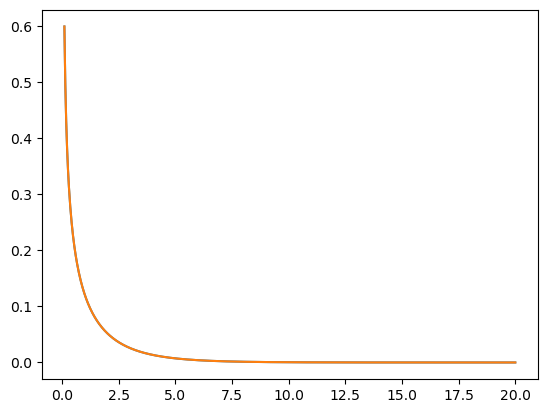

In [8]:
plt.plot(ts, qmu.asympotic_approximation_pdf(ts, 1))
plt.plot(ts, qmu.asympotic_approximation_pdf_scipy(ts, 1))

In [9]:
from titrate.datasets import AsimovMapDataset

asi_dataset = AsimovMapDataset.from_MapDataset(meas_dataset)
qmu_asi = QMuTestStatistic(asi_dataset, poi_name='scale')

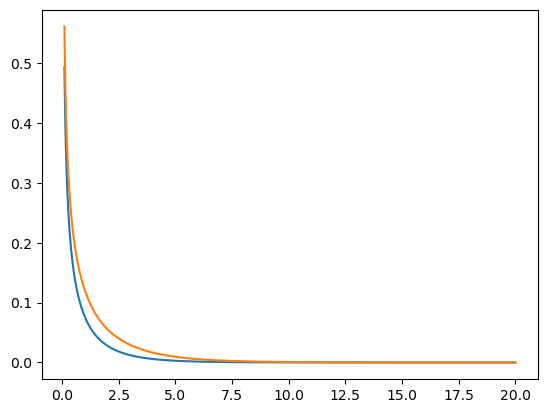

In [20]:
plt.plot(ts, qmu_asi.asympotic_approximation_pdf(ts, 0, same=False, poi_true_val=1))
plt.plot(ts, 0.5 * qmu_asi.asympotic_approximation_pdf_scipy(ts, 0, same=False, poi_true_val=1))

In [13]:
ts

array([ 0.1       ,  0.11991992,  0.13983984,  0.15975976,  0.17967968,
        0.1995996 ,  0.21951952,  0.23943944,  0.25935936,  0.27927928,
        0.2991992 ,  0.31911912,  0.33903904,  0.35895896,  0.37887888,
        0.3987988 ,  0.41871872,  0.43863864,  0.45855856,  0.47847848,
        0.4983984 ,  0.51831832,  0.53823824,  0.55815816,  0.57807808,
        0.597998  ,  0.61791792,  0.63783784,  0.65775776,  0.67767768,
        0.6975976 ,  0.71751752,  0.73743744,  0.75735736,  0.77727728,
        0.7971972 ,  0.81711712,  0.83703704,  0.85695696,  0.87687688,
        0.8967968 ,  0.91671672,  0.93663664,  0.95655656,  0.97647648,
        0.9963964 ,  1.01631632,  1.03623624,  1.05615616,  1.07607608,
        1.095996  ,  1.11591592,  1.13583584,  1.15575576,  1.17567568,
        1.1955956 ,  1.21551552,  1.23543544,  1.25535536,  1.27527528,
        1.2951952 ,  1.31511512,  1.33503504,  1.35495495,  1.37487487,
        1.39479479,  1.41471471,  1.43463463,  1.45455455,  1.47